In [1]:
import h5py
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
data = h5py.File("outputs/output_first_300filt_7000test.h5", 'r')
data1 = h5py.File("outputs/output_300filt_500test_withtargets.h5", 'r')

In [18]:
influence_first = data['filter_infl'].value + 1
influence_second = data1['filter_infl'].value + 1

In [19]:
df = pd.read_csv("motifs_out/table.txt", sep=" *", index_col=0)
df.loc[:, 'importance'] = influence_first

/home/a/.conda/envs/basset/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/a/.conda/envs/basset/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/a/.conda/envs/basset/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


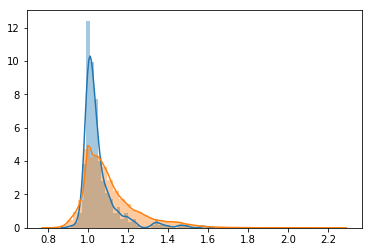

In [20]:
sns.distplot(influence_first.ravel())
sns.distplot(influence_second.ravel())

In [21]:
expected = np.zeros((300,300))

In [22]:
for i in range(0,300,1):
    for j in range(0,300,1):
        expected[i,j] = influence_first[i]*influence_first[j]

In [23]:
print(expected)

[[ 1.01288089  0.98246758  1.16453674 ...,  1.10630237  1.3513823
   1.03661511]
 [ 0.98246758  0.95296747  1.12956973 ...,  1.07308393  1.31080496
   1.00548914]
 [ 1.16453674  1.12956973  1.3388996  ...,  1.27194596  1.55372102
   1.19182462]
 ..., 
 [ 1.10630237  1.07308393  1.27194596 ...,  1.20834043  1.47602492
   1.13222568]
 [ 1.3513823   1.31080496  1.55372102 ...,  1.47602492  1.80300974
   1.38304841]
 [ 1.03661511  1.00548914  1.19182462 ...,  1.13222568  1.38304841
   1.06090548]]


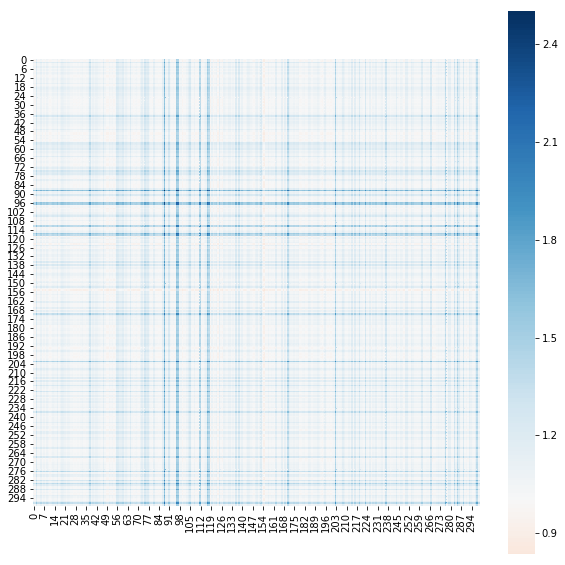

In [24]:
plt.figure(figsize=[10,10])
sns.heatmap(expected, cmap='RdBu', center = 1, square=True)

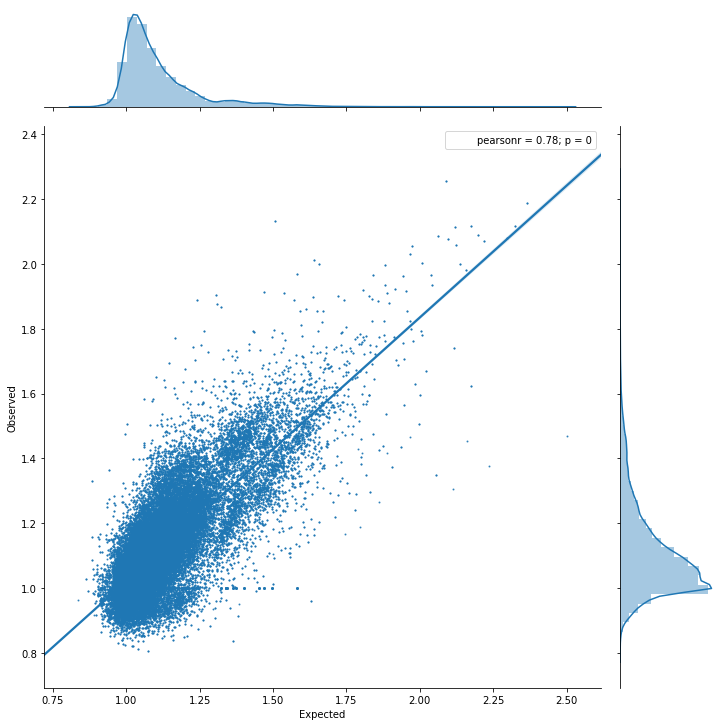

In [25]:
sns.jointplot(np.array(expected.ravel()), np.array(influence_second.ravel()), kind='reg', size = 10, scatter_kws={'s':1})
plt.ylabel('Observed')
plt.xlabel('Expected')

In [51]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = expected.ravel().reshape(-1, 1)
predict = influence_second.ravel().reshape(-1, 1)

th_X = (np.percentile(X, 1), np.percentile(X, 99))
th_predict = (np.percentile(predict, 1), np.percentile(predict, 99))
#mask = (X>th_X[0])&(X<th_X[1])&(predict>th_predict[0])&(predict<th_predict[1])&(X!=1)&(predict!=1)
mask = (X!=1)&(predict!=1)


model = make_pipeline(LinearRegression()) #PolynomialFeatures(3), L LinearRegression
model.fit(X[mask].reshape(-1, 1), predict[mask].reshape(-1, 1))

observed_corrected = model.predict(X)

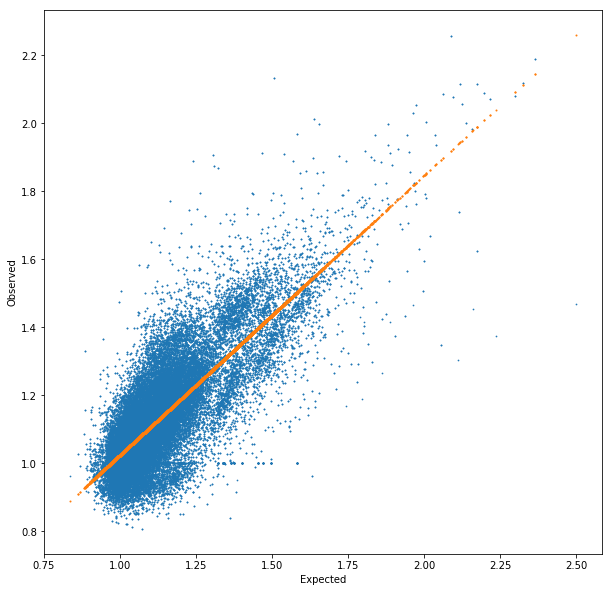

In [52]:
plt.figure(figsize=[10,10])
plt.scatter(np.array(expected.ravel()), np.array(influence_second.ravel()), s=0.5)
plt.scatter(np.array(expected.ravel()), np.array(observed_corrected), s=1)
plt.ylabel('Observed')
plt.xlabel('Expected')

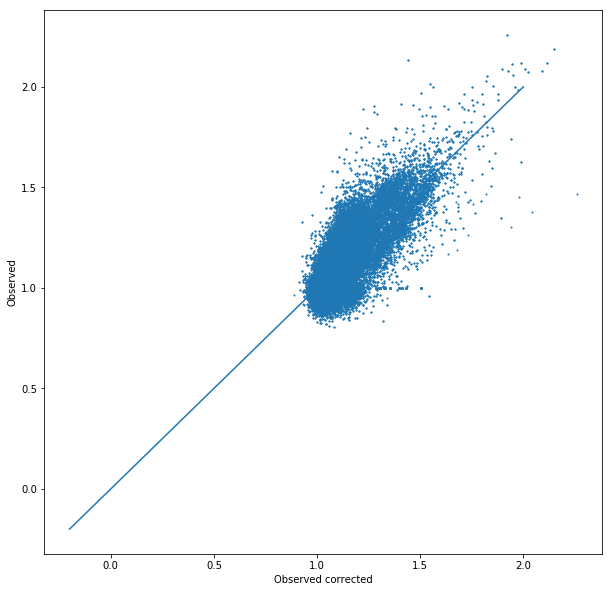

In [53]:
plt.figure(figsize=[10,10])
plt.scatter(np.array(observed_corrected), np.array(influence_second.ravel()), s=1)
plt.ylabel('Observed')
plt.xlabel('Observed corrected')
plt.plot([-0.2,2], [-0.2,2])

In [54]:
expected_final = observed_corrected.reshape([300,300])

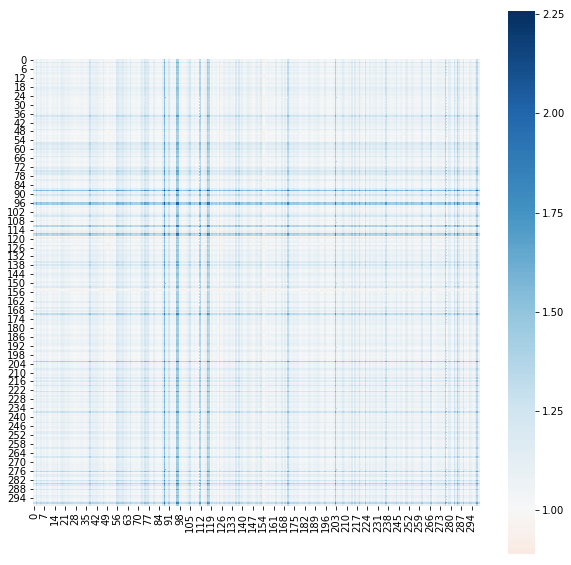

In [55]:
plt.figure(figsize=[10,10])
sns.heatmap(expected_final, cmap='RdBu', center = 1, square=True)

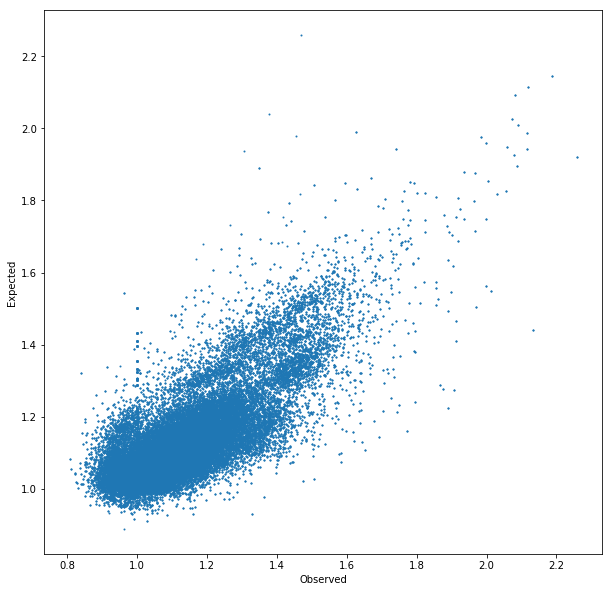

In [56]:
plt.figure(figsize=[10,10])
plt.scatter(np.array(influence_second.ravel()), np.array(expected_final), s=1)
plt.xlabel('Observed')
plt.ylabel('Expected')


In [57]:
enrichment = np.log(influence_second/expected_final)

In [70]:
th = np.percentile(enrichment, 99)

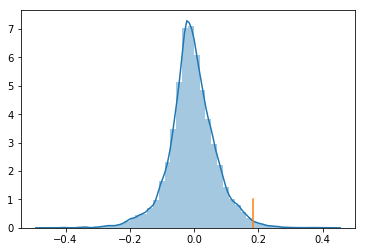

In [71]:
sns.distplot(enrichment.ravel())
plt.plot([th,th], [0,1])

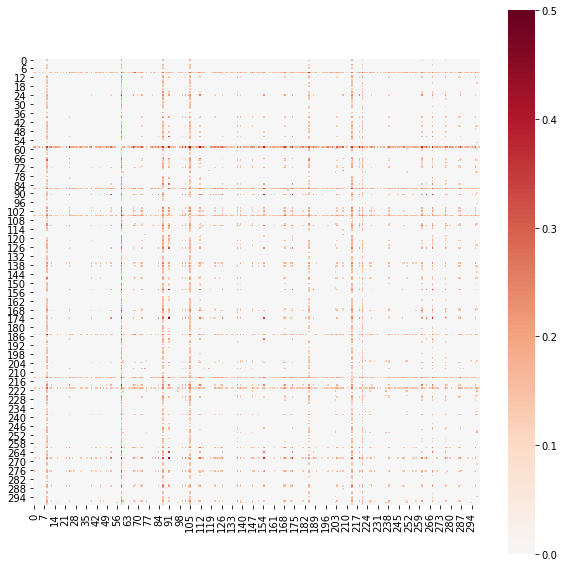

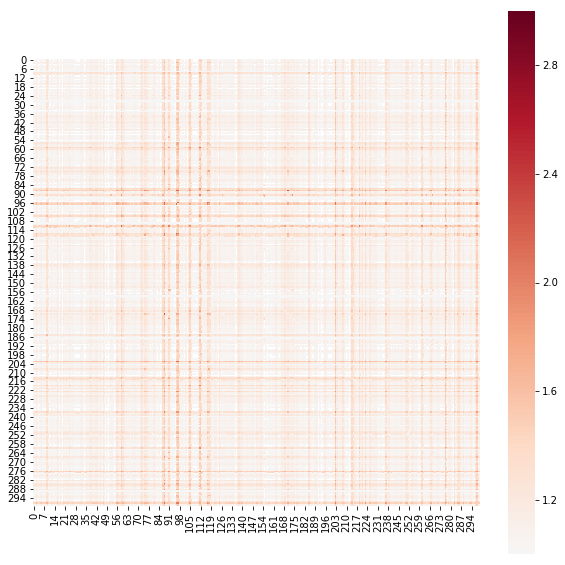

In [64]:
plt.figure(figsize=[10,10])
tmp = enrichment.copy()
tmp[tmp<th] = 0
sns.heatmap(tmp, cmap='RdBu_r', center = 0, vmax=0.5, square=True)
plt.figure(figsize=[10,10])
tmp = influence_second.copy()
tmp[tmp<1] = np.nan
sns.heatmap(tmp, cmap='RdBu_r', center = 1, vmax=3, square=True)

In [72]:
f = open('graph_99_sum.csv','w+')
f.write(';')

used_names = {}
th = np.percentile(enrichment, 99)

for a in range (0,300,1):
    name = df.loc[a,'annotation']
    
    if name in used_names.keys():
        used_names[name] += 1
    else:
        used_names.update({name: 1})
        
    f.write(df.loc[a,'annotation']+"("+str(a+1)+');')
    
used_names = {}    

for i in range(0,300,1):
    
    f.write('\n')
    name = df.loc[i,'annotation']
    
    if name in used_names.keys():
        used_names[name] += 1
    else:
        used_names.update({name: 1})
        
    f.write(df.loc[i,'annotation']+"("+str(i+1)+');')
    
    for j in range(0,300,1):
        if enrichment[i][j] > th:
            f.write(str(enrichment[i][j])+';') 
        else:
            f.write(str(0.0)+';')
f.close()        

(-0.35, 0.35)

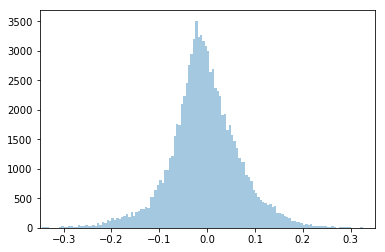

In [67]:
sns.distplot(enrichment.ravel(), bins=np.arange(-0.35,0.35,0.005), kde=False)
plt.xlim([-0.35, 0.35])